In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_datasets as tfds
import os
import matplotlib.pyplot as plt
import vd_generator
import tqdm

c:\Users\ual\.conda\envs\felix\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = tf.keras.models.load_model("training_results/last_model/MNV3L_All/model")
model.load_weights("training_results/weights/MNV3L_All/cp.ckpt")

In [3]:
_,val_ds = vd_generator.get_train_and_val()


In [4]:
model.evaluate(val_ds)

287/287 [==============================] - 11s 23ms/step - loss: 0.5522 - accuracy: 0.8965


[0.5522230267524719, 0.896504819393158]

In [5]:
inputs = tf.keras.Input([260,260,3])
x = tf.keras.layers.Resizing(224,224) ( inputs)

base = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_tensor= x)

base.trainable = False
# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(3, activation="softmax", name="pred",kernel_regularizer=tf.keras.regularizers.L2())(x)

# Compile
with_out_aug_model = tf.keras.Model(inputs, outputs, name="with_out_aug")
for layer in with_out_aug_model.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [6]:
for old,new in zip(model.layers[2:],with_out_aug_model.layers[1:]):

    try:
        with_out_aug_model.get_layer(new.name).set_weights(model.get_layer(old.name).get_weights())
    except:
        print(new.name)
with_out_aug_model.compile(tf.keras.optimizers.Adam(),loss = tf.keras.losses.BinaryCrossentropy(),metrics=["accuracy"])
with_out_aug_model.evaluate(val_ds)

287/287 [==============================] - 8s 24ms/step - loss: 0.3205 - accuracy: 0.8965


[0.32053008675575256, 0.896504819393158]

In [7]:
test_ds = vd_generator.get_test_ds()
model.evaluate(test_ds)

251/251 [==============================] - 6s 23ms/step - loss: 0.5652 - accuracy: 0.8650


[0.5651649236679077, 0.8649775981903076]

In [8]:
with_out_aug_model.evaluate(test_ds)

251/251 [==============================] - 6s 23ms/step - loss: 0.3414 - accuracy: 0.8650


[0.34140661358833313, 0.8649775981903076]

In [9]:
preds = np.argmax(with_out_aug_model.predict(test_ds),axis=1)
_,val_df,test_df = vd_generator.get_csv()
to_numbers ={"Forward":0, "Backward":1,"Sideways":2}
labels = test_df["view_direction"].map(to_numbers)[:len(preds)]
failure_mask = preds != labels
failed_images = test_df[:len(preds)][failure_mask]
wrong_preds = preds[failure_mask]
wrong_labels = labels[failure_mask]
imgs = np.concatenate([i for i,a in tfds.as_numpy(test_ds)])
len(failed_images)

2169

 14%|█▍        | 304/2169 [05:19<32:39,  1.05s/it]  


KeyboardInterrupt: 

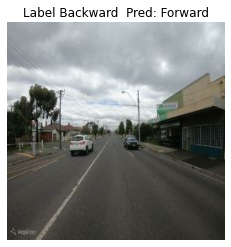

In [14]:
dic = dict(zip(to_numbers.values(),to_numbers.keys()))


def save_n_wrong_images(n):
    for i in tqdm.tqdm(range(n)):

        plt.imshow(imgs[failure_mask][i])
        plt.axis('off')

        label = dic[wrong_labels.values[i]]
        pred = dic[wrong_preds[i]]

        plt.title(f"Label {label}  Pred: {pred}")
        plt.savefig(f"../wrong_labels/{test_df.index[i]}.jpg")



In [1]:
preds

NameError: name 'preds' is not defined

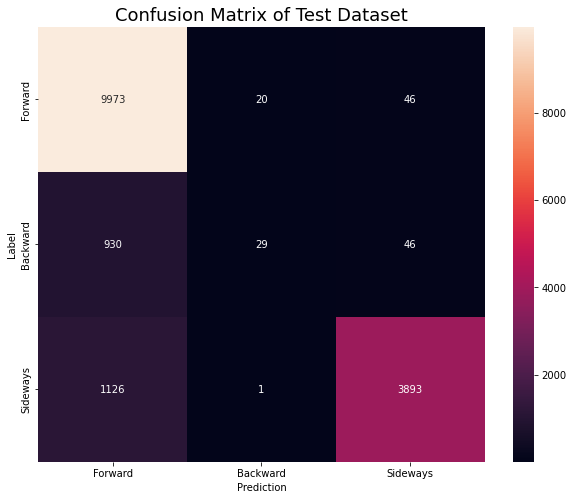

In [15]:
confusion_mtx = tf.math.confusion_matrix(labels,preds)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

names = list(dic.values())

sns.heatmap(confusion_mtx, xticklabels=names, yticklabels=names, 
          annot=True, fmt='g')
plt.title("Confusion Matrix of Test Dataset",fontsize=18)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig("../Imgs/Confusion_Matrix.jpg")
plt.show()